In [1]:
import scanpy as sc
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import sys, pathlib
repo_root = pathlib.Path('./st-celltype-deconvolution/src/models').resolve()
sys.path.insert(0, str(repo_root))

from vae_sc import VAE, vae_loss, compute_uncertainty
from uncertainty_gcn import UncertaintyGCN, compute_loss

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ================== 1. 读取数据 ==================
scRNA = sc.read_h5ad("../scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad")
ST_train = sc.read_h5ad("./sim_pseudospots_split/train.h5ad")
ST_val   = sc.read_h5ad("./sim_pseudospots_split/val.h5ad")
ST_test  = sc.read_h5ad("./sim_pseudospots_split/test.h5ad")

genes = scRNA.var_names.intersection(ST_train.var_names)
scRNA = scRNA[:, genes]
ST_train = ST_train[:, genes]
ST_val   = ST_val[:, genes]
ST_test  = ST_test[:, genes]

celltypes = scRNA.obs["cell_types"].astype("category").cat.categories.tolist()

In [3]:
# python
def inspect_expr(X, name="X"):
    import numpy as np
    X_np = X.A if hasattr(X, "A") else np.asarray(X)
    print(name, "shape:", X_np.shape)
    print("min/max/median/mean:", X_np.min(), X_np.max(), np.median(X_np), X_np.mean())
    print("per-cell total: mean,median:", X_np.sum(axis=1).mean(), np.median(X_np.sum(axis=1)))
    print("sparsity:", 1.0 - (X_np!=0).sum()/X_np.size)

inspect_expr(scRNA.X, "scRNA")
inspect_expr(ST_train.X, "ST_train")
# inspect_expr(st_subset.X, "st_subset")

scRNA shape: (14989, 1888)
min/max/median/mean: 0.0 11.301362 0.0 0.7311078
per-cell total: mean,median: 1380.3312 1298.3159
sparsity: 0.8524238042926394
ST_train shape: (489, 1888)
min/max/median/mean: 0 194 0.0 4.0856989359121005
per-cell total: mean,median: 7713.799591002045 7424.0
sparsity: 0.6452430158400055


In [ ]:
# # python
# def preprocess_log1p_cpm(adata):
#     X = adata.X.A if hasattr(adata.X, "A") else np.asarray(adata.X)
#     libsize = X.sum(axis=1, keepdims=True) + 1e-6
#     X_cpm = X / libsize * 1e6
#     X_log = np.log1p(X_cpm)
#     return X_log

# X_sc_log = preprocess_log1p_cpm(scRNA)
# X_st_log = preprocess_log1p_cpm(ST_train)
# # 确认 shape 和基因顺序一致
# assert X_sc_log.shape[1] == X_st_log.shape[1]

In [ ]:
# # ================== 2. 训练 VAE ==================
# X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
# X_sc = torch.tensor(X_sc, dtype=torch.float32)
# labels = scRNA.obs["cell_types"].astype("category").cat.codes.values
# labels = torch.tensor(labels, dtype=torch.long)

# dataset = TensorDataset(X_sc, labels)
# dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# vae = VAE(input_dim=X_sc.shape[1], hidden_dim=128, latent_dim=16)
# opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

# epochs = 50
# for epoch in range(epochs):
#     vae.train()
#     total_loss, total_recon, total_kl = 0, 0, 0
#     for x_batch, _ in dataloader:
#         opt.zero_grad()
#         x_hat, mu, logvar = vae(x_batch)
#         loss, recon, kl = vae_loss(x_batch, x_hat, mu, logvar)
#         loss.backward()
#         opt.step()
#         total_loss += loss.item()
#         total_recon += recon.item()
#         total_kl += kl.item()
#     if (epoch+1) % 10 == 0:
#         print(f"VAE Epoch {epoch+1}/{epochs}, loss={total_loss:.2f}, recon={total_recon:.2f}, kl={total_kl:.2f}")

VAE Epoch 10/50, loss=200.96, recon=191.07, kl=9.90
VAE Epoch 20/50, loss=198.31, recon=188.09, kl=10.22
VAE Epoch 30/50, loss=197.59, recon=187.32, kl=10.27
VAE Epoch 40/50, loss=196.85, recon=186.09, kl=10.75
VAE Epoch 50/50, loss=196.45, recon=185.58, kl=10.87


VAE Epoch 10/50, loss_avg=1.4189, recon_avg=1.4142, kl_avg=4.6369
VAE Epoch 20/50, loss_avg=1.3986, recon_avg=1.3944, kl_avg=4.1941
VAE Epoch 30/50, loss_avg=1.3916, recon_avg=1.3876, kl_avg=4.0141
VAE Epoch 40/50, loss_avg=1.3867, recon_avg=1.3828, kl_avg=3.9360
VAE Epoch 50/50, loss_avg=1.3839, recon_avg=1.3800, kl_avg=3.8767


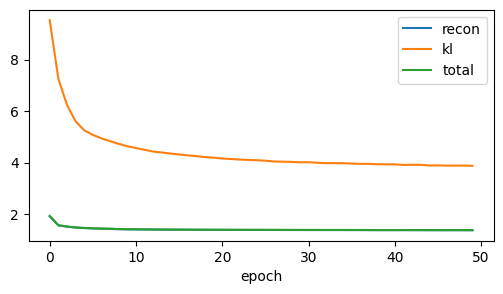

type_unc (first 10): [0.14922495 0.14381512 0.760142   0.         0.7462     0.06780732
 1.         0.59715414 0.04690453 0.45797184]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
X_sc = torch.tensor(X_sc, dtype=torch.float32)
labels = scRNA.obs["cell_types"].astype("category").cat.codes.values
labels = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(X_sc, labels)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=X_sc.shape[1], hidden_dim=128, latent_dim=16).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 50
n_batches = len(dataloader)
recon_hist, kl_hist, loss_hist = [], [], []
for epoch in range(1, epochs+1):
    vae.train()
    sum_loss = sum_recon = sum_kl = 0.0
    for x_batch, _ in dataloader:
        x_batch = x_batch.to(device)
        opt.zero_grad()
        x_hat, mu, logvar = vae(x_batch)                      # forward -> x_hat, mu, logvar
        loss, recon, kl = vae_loss(x_batch, x_hat, mu, logvar, beta=1e-3)
        loss.backward()
        opt.step()
        sum_loss += loss.item()
        sum_recon += recon.item() if isinstance(recon, torch.Tensor) else float(recon)
        sum_kl += kl.item() if isinstance(kl, torch.Tensor) else float(kl)

    loss_avg = sum_loss / n_batches
    recon_avg = sum_recon / n_batches
    kl_avg = sum_kl / n_batches
    loss_hist.append(loss_avg); recon_hist.append(recon_avg); kl_hist.append(kl_avg)

    if epoch % 10 == 0:
        print(f"VAE Epoch {epoch}/{epochs}, loss_avg={loss_avg:.4f}, recon_avg={recon_avg:.4f}, kl_avg={kl_avg:.4f}")

# 绘图用于诊断
plt.figure(figsize=(6,3))
plt.plot(recon_hist, label="recon"); plt.plot(kl_hist, label="kl"); plt.plot(loss_hist, label="total")
plt.legend(); plt.xlabel("epoch"); plt.show()

# 训练后计算 type-level 不确定性（注意 compute_uncertainty 的 dataloader 要产出 (x, label)）
n_types = len(celltypes)
sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
# RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(vae, sc_loader_for_unc, device=device)
RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
    vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
)
# 归一化选择一个 type_unc（例如 RE_c）
type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
print("type_unc (first 10):", type_unc[:10])

vae训练完毕